In [0]:
# Makes plots / images embedded in the file
%matplotlib inline

In [0]:
from zipfile import ZipFile
from urllib.request import urlopen
import numpy as np

URL = 'https://uwmadison-cs534-term-project-f2018-cdh.github.io/assets/datasets/items.zip'

url = urlopen(URL)
output = open('items.zip','wb')
output.write(url.read())
output.close()

zip_ref = ZipFile('items.zip', 'r')
zip_ref.extractall('./dataset')
zip_ref.close()

In [0]:
# Import data and keras layers
import keras
from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Dense, Reshape, Conv2DTranspose
from keras.layers import Flatten, Dropout, BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

In [23]:
import os

files = os.listdir('./dataset/items')
for name in files:
    print(name)

items_image.npy
items_label.npy


In [0]:
x1_raw = np.load('./dataset/items/items_image.npy')
y1_raw = np.load('./dataset/items/items_label.npy')

x1_test = np.array([])
y1_test = np.array([])

#Optimizer
adam = Adam(lr=2e-4, beta_1=0.5)

In [25]:
# Generate labels

y1_coded = {}
for lbl in y1_raw:
  if not lbl in y1_coded.keys():
    index = len(y1_coded.keys())
    code = bin(index)[2:]
    code = ([0] * (10 - len(code))) + [int(c) for c in list(code)]
    y1_coded[lbl] = code
    print(code,index,lbl)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0 items_knowledge_book
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 1 items_knowledge_book_artefact
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 2 items_wearable_jewlery_ring
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1] 3 items_resources_potion
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 4 items_knowledge_cards
[0, 0, 0, 0, 0, 0, 0, 1, 0, 1] 5 items_knowledge_glyphs
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0] 6 items_knowledge_runes
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1] 7 items_knowledge_scroll
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0] 8 items_resources_common
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1] 9 items_resources_crafted
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0] 10 items_resources_food
[0, 0, 0, 0, 0, 0, 1, 0, 1, 1] 11 items_resources_gems
[0, 0, 0, 0, 0, 0, 1, 1, 0, 0] 12 items_resources_metals
[0, 0, 0, 0, 0, 0, 1, 1, 0, 1] 13 items_resources_organic
[0, 0, 0, 0, 0, 0, 1, 1, 1, 0] 14 items_tools_broken
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1] 15 items_tools_close-weapon
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 16 items_tools_farming-crafting
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1] 

In [26]:
import math
number_bits_used_in_label = math.ceil(math.log(len(y1_coded.keys()),2))
print(number_bits_used_in_label)

6


In [0]:
filterLbls = [
    'items_tools_close-weapon',
    'items_tools_rod',
    'items_tools_scepter',
    'items_tools_staff',
    'items_tools_wands'
  ]

y1_train = []

firstTime = True
for i in range(y1_raw.shape[0]):
  
  if y1_raw[i] in filterLbls:
    y1_train.append(y1_coded[y1_raw[i]])
    
    if firstTime:
      firstTime = False
      raw = x1_raw[i,:,:,:]
      x1_train = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
    else:
      raw = x1_raw[i,:,:,:]
      raw = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
      x1_train = np.concatenate((x1_train,raw), axis=0)
    
y1_train = np.array(y1_train)


In [29]:
# Creating the generator

def createGenerator():
  input1 = Input(shape=(100,))
  input2 = Input(shape=(10,))

  x = keras.layers.Concatenate(axis=-1)([input1,input2])
  x = Dense(512*4*4, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Reshape((4, 4, 512))(x)
  x = Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', activation='relu')(x)
  x = Conv2DTranspose(128, (5, 5), strides=(2,2), padding='same', activation='relu')(x)
  out = Conv2DTranspose(4, (5, 5), strides=(2,2), padding='same', activation='tanh')(x)
  
  return keras.models.Model(inputs=[input1,input2], outputs=out)

generator = createGenerator()

print(generator.summary())
generator.compile(loss = 'binary_crossentropy', optimizer = adam)  

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 110)          0           input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 8192)         909312      concatenate_4[0][0]              
__________

In [30]:
# Creating the discriminator

def createDiscriminator():
  input1 = Input(shape=(32, 32, 4))
  x1 = Conv2D(32, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(input1)
  x1 = LeakyReLU(0.2)(x1)
  x1 = Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(x1)
  x1 = LeakyReLU(0.2)(x1)
  x1 = Conv2D(128, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(x1)
  x1 = LeakyReLU(0.2)(x1)
  x1 = Flatten()(x1)
  x1 = Dropout(0.3)(x1)

  input2 = Input(shape=(10,))

  x3 = keras.layers.Concatenate(axis=-1)([x1,input2])
  x3 = Dense(64, activation = 'relu')(x3)
  out = Dense(1, activation = 'sigmoid')(x3)

  return keras.models.Model(inputs=[input1,input2], outputs=out)

discriminator = createDiscriminator()

print(discriminator.summary())
discriminator.compile(loss = 'binary_crossentropy', optimizer = adam) 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 32, 4)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 32)   3232        input_11[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 16, 16, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 64)     51264       leaky_re_lu_4[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [31]:
# Create the GAN
discriminator.trainable = False

def createGAN():
  input_1 = Input(shape=(100,))
  input_2 = Input(shape=(10,))
  x = generator([input_1,input_2])
  out = discriminator([x,input_2])
  return keras.models.Model(inputs=[input_1,input_2], outputs=out)

gan = createGAN()

print(discriminator.summary())
gan.compile(loss = 'binary_crossentropy', optimizer = adam)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 32, 4)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 32)   3232        input_11[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 16, 16, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 64)     51264       leaky_re_lu_4[0][0]              
__________________________________________________________________________________________________
leaky_re_l

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
# Visualize generated data
def plotGeneratedImages():
  
  noise = np.random.uniform(-1, 1, size=[9, 100])
  gen_label = np.concatenate((
            np.reshape(np.array([0]*(10-number_bits_used_in_label)*9),(9,(10-number_bits_used_in_label))), 
            np.around(np.random.uniform(0, 1, size=[9, number_bits_used_in_label]))),axis=1)
  
  generated_images = generator.predict([noise,gen_label])
  fig = plt.figure(figsize=(9, 9))        
  for i in range(9 if generated_images.shape[0] > 9 else generated_images.shape[0]):
    plt.subplot(3, 3, i+1)
    img = np.clip(generated_images[i, :],0,1)
    img = img.reshape((32, 32, 4))
    plt.tight_layout()
    plt.imshow(img)
    plt.axis('off')

999: 100%|██████████| 51/51 [00:02<00:00, 18.05it/s]


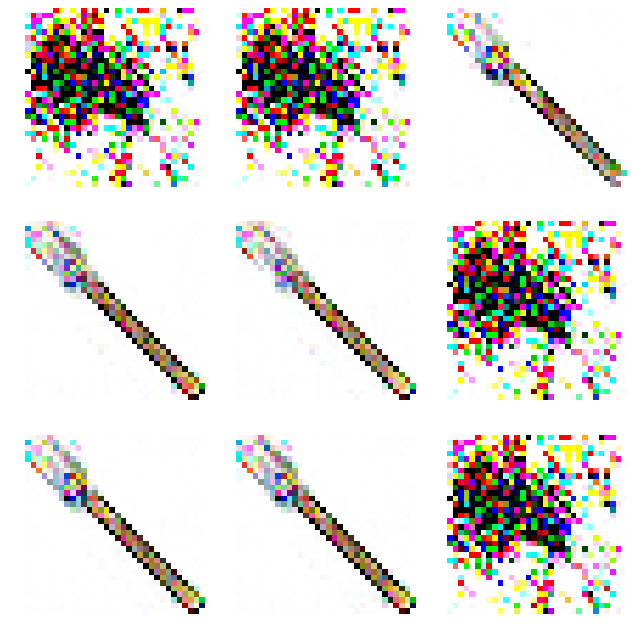

In [33]:
epochs = 1000
batch_size = 16

batch_count = int(x1_train.shape[0] / batch_size)

for epoch in range(epochs):

    for index in tqdm(range(batch_count), desc=""+str(epoch)):
        
        # Real images
        image_batch = x1_train[index * batch_size: (index + 1) * batch_size]
        image_label = y1_train[index * batch_size: (index + 1) * batch_size]
        
        # Get initial random input for generator
        noise = np.random.uniform(-1, 1, size=[batch_size, 100])
        gen_label = np.concatenate((
            np.reshape(np.array([0]*(10-number_bits_used_in_label)*batch_size),(batch_size,(10-number_bits_used_in_label))), 
            np.around(np.random.uniform(0, 1, size=[batch_size, number_bits_used_in_label]))),axis=1)
        
        # Generating images
        generated_data = generator.predict_on_batch([noise,gen_label])

        # Train discriminator
        X = np.concatenate((image_batch,generated_data))
        xl = np.concatenate((image_label,gen_label))
        y = np.concatenate((np.zeros(image_batch.shape[0]),np.ones(batch_size)))
        
        discriminator.trainable = True
        discriminator.train_on_batch(x=[X,xl], y=y)
        
        # Train generator 
        y = np.zeros(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(x=[noise,gen_label], y=y)
        
        img = generated_images = generator.predict([noise,gen_label])   
        
    
plotGeneratedImages()


In [0]:
plotGeneratedImages()

In [0]:
from google.colab import files
import matplotlib.image as mpimg
import uuid

images = 20
noise = np.random.uniform(-1, 1, size=[images, 100])
generated_images = generator.predict(noise)    
for i in range(images):
  name = str(uuid.uuid4().hex) + '.png'
  img = np.reshape(np.clip(generated_images[i, :],0,1),(32, 32, 4))
  mpimg.imsave(name, img)             
  files.download(name)


In [0]:
from keras.models import load_model
from google.colab import files

model_name = 'dcgan-sprite-item-weapon-3000-epoch.h5'
gan.save(model_name)
files.download(model_name)
